In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
!pip install UMAP
!pip install BERTopic
import re
import json
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file = 'meta_Musical_Instruments.jsonl.gz'

products = []

with open(file, 'r') as fp:
    for line in fp:
        products.append(json.loads(line.strip()))

In [22]:
# Subset all of the info to only include relevant fields
relevant_fields = ['title', 'rating_number', 'features', 'description']
products = [{field:product[field] for field in relevant_fields} for product in products]

# Combine features and description and remove unusual characters such as emojis.
for product in products:
    product['combined_description'] = re.sub(r'[^a-zA-Z0-9\s]', '', ' '.join(product['description'] + product['features'])).strip()

In [23]:
num_ratings = []

for product in products:
    num_ratings.append(product['rating_number'])

num_ratings = np.array(num_ratings)

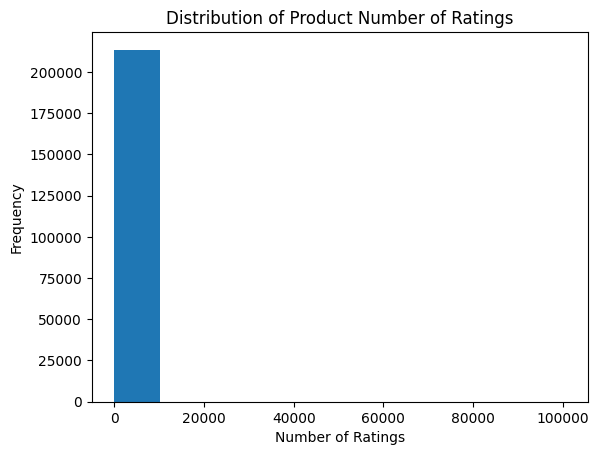

In [24]:
plt.hist(num_ratings, bins=10)
plt.title('Distribution of Product Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [25]:
# Top 2000 products by number of ratings have at least this many
sorted(num_ratings)[-20000]

134

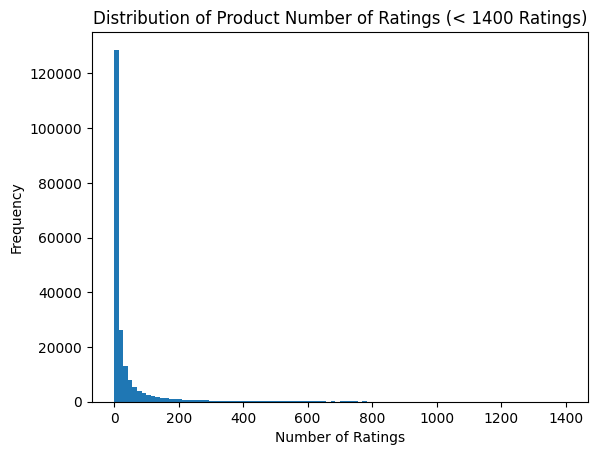

In [26]:
plt.hist(num_ratings[num_ratings < 1400], bins=100)
plt.title('Distribution of Product Number of Ratings (< 1400 Ratings)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

In [27]:
ratings_threshold = 50
filtered_products = [product for product in products if product['rating_number'] > ratings_threshold]

print(f"There are now {len(filtered_products)} remaining products.")
lengths = []
has_features = 0

There are now 40931 remaining products.


In [28]:
lengths = []
has_features = 0
has_description = 0

for product in filtered_products:
    lengths.append(len(product['combined_description']))
    if len(product['features']) > 0:
        has_features += 1

    if len(product['description']) > 0:
        has_description += 1

lengths = np.array(lengths)

In [29]:
print(f"Proportion of products with features: {has_features / len(filtered_products) * 100}")
print(f"Proportion of products with descriptions: {has_description / len(filtered_products) * 100}")

Proportion of products with features: 92.25770198626958
Proportion of products with descriptions: 64.21783000659647


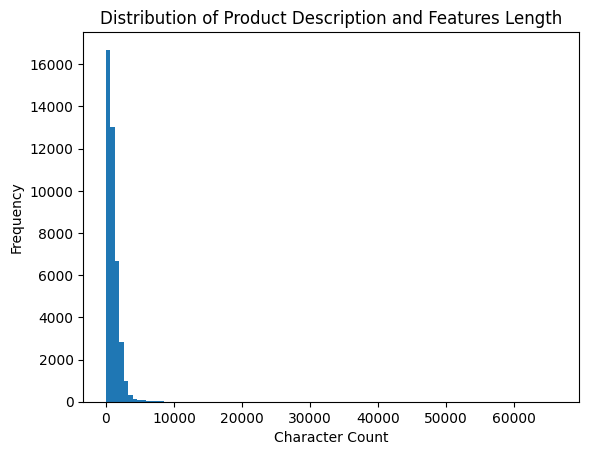

In [30]:
plt.hist(lengths, bins=100)
plt.title('Distribution of Product Description and Features Length')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

In [31]:
description_threshold = 950

final_products = [product for product in filtered_products if len(product['combined_description']) > description_threshold]

print(f"There are now {len(final_products)} remaining products.")

There are now 17935 remaining products.


In [32]:
products_df = pd.DataFrame(final_products)
products_df.to_csv('musical_instruments.csv', index=False)

In [33]:
class ProductGroupGenerator:
    def __init__(self, min_cluster_size=5, max_clusters=75):
        self.sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
        self.tfidf = TfidfVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 2)
        )
        self.min_cluster_size = min_cluster_size
        self.max_clusters = max_clusters

    def preprocess_text(self, text):
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text).lower())
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def generate_clusters(self, texts, method='combined', n_clusters=None):
        """
        Generate product clusters using different methods

        Args:
            texts: List of product titles/descriptions
            method: One of 'tfidf_kmeans', 'bert_topic', or 'combined'
            n_clusters: Optional target number of clusters
        """
        if n_clusters is None:
            n_clusters = min(len(texts) // self.min_cluster_size, self.max_clusters)

        processed_texts = [self.preprocess_text(text) for text in texts]

        if method == 'tfidf_kmeans':
            return self._cluster_tfidf_kmeans(processed_texts, n_clusters)
        elif method == 'bert_topic':
            return self._cluster_bert_topic(processed_texts)
        elif method == 'combined':
            return self._cluster_combined(processed_texts, n_clusters)
        else:
            raise ValueError("Invalid clustering method")

    def _cluster_tfidf_kmeans(self, texts, n_clusters):
        # Transform texts to TF-IDF vectors
        tfidf_matrix = self.tfidf.fit_transform(texts)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(tfidf_matrix)

        # Get top terms for each cluster
        cluster_terms = {}
        feature_names = self.tfidf.get_feature_names_out()
        for i in range(n_clusters):
            center_indices = kmeans.cluster_centers_[i].argsort()[::-1][:5]
            cluster_terms[i] = [feature_names[idx] for idx in center_indices]

        return labels, cluster_terms

    def _cluster_bert_topic(self, texts):
        # Create embeddings
        embeddings = self.sentence_model.encode(texts)

        # Initialize BERTopic
        topic_model = BERTopic(
            umap_model=UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
            hdbscan_model=hdbscan.HDBSCAN(
                min_cluster_size=self.min_cluster_size,
                min_samples=1,
                metric='euclidean',
                cluster_selection_method='eom'
            ),
            verbose=True
        )

        # Fit the model and get topics
        labels, _ = topic_model.fit_transform(texts, embeddings)

        # Get topic terms
        topic_terms = {}
        for topic_idx, words in topic_model.get_topics().items():
            topic_terms[topic_idx] = [word[0] for word in words[:5]]

        return labels, topic_terms

    def _cluster_combined(self, texts, n_clusters):
        # Get clusters from both methods
        print("CLUSTERING BY KMEANS")
        kmeans_labels, kmeans_terms = self._cluster_tfidf_kmeans(texts, n_clusters)
        print("CLUSTERING BY BERT")
        bert_labels, bert_terms = self._cluster_bert_topic(texts)

        # Create ensemble clustering
        # Convert labels to one-hot encoding
        def one_hot_encode(labels):
            n_unique = len(np.unique(labels))
            return np.eye(n_unique)[labels]

        kmeans_oh = one_hot_encode(kmeans_labels)
        bert_oh = one_hot_encode(bert_labels)

        # Concatenate features
        combined_features = np.hstack([kmeans_oh, bert_oh])

        # Final clustering on combined features
        print("CREATING FINAL CLUSTERING COMBINATION")
        final_kmeans = KMeans(n_clusters=n_clusters)
        final_labels = final_kmeans.fit_predict(combined_features)

        # Combine terms from both methods for final clusters
        final_terms = {}
        for i in range(n_clusters):
            terms_set = set()
            terms_set.update(kmeans_terms.get(i, []))
            terms_set.update(bert_terms.get(i, []))
            final_terms[i] = list(terms_set)[:5]

        return final_labels, final_terms

    def analyze_clusters(self, texts, labels, cluster_terms):
        """
        Analyze cluster quality and characteristics
        """
        cluster_stats = {}
        unique_labels = np.unique(labels)

        for label in unique_labels:
            cluster_texts = [texts[i] for i in range(len(texts)) if labels[i] == label]
            cluster_stats[label] = {
                'size': len(cluster_texts),
                'terms': cluster_terms.get(label, []),
                'sample_products': cluster_texts[:3]  # Show 3 example products
            }

        return cluster_stats

In [34]:
# Prepare your data
products_df = pd.read_csv('musical_instruments.csv')
texts = products_df['title'] + ' ' + products_df['description']

In [19]:
# Initialize clustering class
generator = ProductGroupGenerator(min_cluster_size=75, max_clusters = 150)

In [36]:
from bertopic import BERTopic
import hdbscan
from umap import UMAP

In [37]:
# Run clustering
labels, cluster_terms = generator.generate_clusters(texts, method='combined')

CLUSTERING BY KMEANS
CLUSTERING BY BERT


2025-02-08 19:47:38,744 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-08 19:48:26,357 - BERTopic - Dimensionality - Completed ✓
2025-02-08 19:48:26,360 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-08 19:48:35,448 - BERTopic - Cluster - Completed ✓
2025-02-08 19:48:35,479 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-08 19:48:39,798 - BERTopic - Representation - Completed ✓


CREATING FINAL CLUSTERING COMBINATION


In [38]:
# Analyze the clusters
cluster_stats = generator.analyze_clusters(texts, labels, cluster_terms)

In [39]:
products_df.shape[0]

17935

In [40]:
len(cluster_stats)

150

In [41]:
for i in range(10):
    print(f"Cluster Size: {cluster_stats[i]['size']}")
    print(f"Key Terms: {', '.join(cluster_stats[i]['terms'])}\n")

Cluster Size: 73
Key Terms: lights, remote control, recording, condenser, cardioid

Cluster Size: 1123
Key Terms: sound, pro, case, rack, bag

Cluster Size: 332
Key Terms: width, ukulele, 12, strings, soprano

Cluster Size: 163
Key Terms: cymbals, drum, pad, guitar stand, stand

Cluster Size: 234
Key Terms: foam, sound, strings, 12, set

Cluster Size: 274
Key Terms: lights, musical instruments, lighting, musical, led

Cluster Size: 104
Key Terms: arm, stand, mic, lavalier microphone, lavalier

Cluster Size: 129
Key Terms: mount, guitar wall, leather, straps, hanger

Cluster Size: 232
Key Terms: cables, strings, male, string, bronze

Cluster Size: 79
Key Terms: ukulele, input, recording, concert, interface



In [42]:
num_items = []

for cluster in cluster_stats.keys():
    num_items.append(cluster_stats[cluster]['size'])

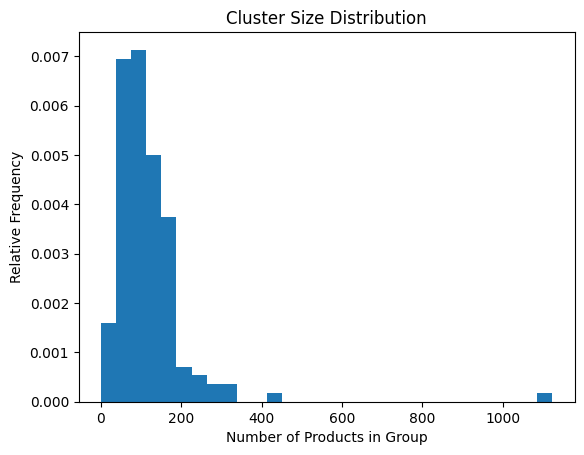

In [43]:
plt.hist(num_items, bins=30, density=True)
plt.title("Cluster Size Distribution")
plt.xlabel("Number of Products in Group")
plt.ylabel("Relative Frequency")
plt.show()

In [44]:
products_df['label'] = labels
products_df['label'].value_counts()[:5]

,count
label,
1,1123
89,436
2,332
64,322
5,274


In [48]:
# Largest Group Info
cluster_stats[4]

{'size': 234,
 'terms': ['foam', 'sound', 'strings', '12', 'set'],
 'sample_products': ['BestSounds Guitar Strap for Acoustic, Electric Bass Guitars with Pick Holders for Men Women and Kids [\'Features:\', \'﹣Unique design.The leather ends with 3 Pick Holders, convenient and easy to carry your guitar picks ﹣Comfortable made. Our new stylish guitar strap is made of 100% cotton. ﹣thicker and heavier, more solid compare with other guitar straps. Fine stitching and comfortable to wear ﹣2" wide so the guitar isn\\\'t so heavy on your shoulder. With this strap, your guitar will not slip off ﹣leather end, top grade cotton material, No fading & washable. ﹣Fully adjustable length from 36.5" to 61.5"(93cm-156cm),to fit for man, women and kids.\', \'BestSounds brand is committed to give customer an excellent shopping experience ,if you have any questions, please do not hesitate to contact us, We will reply you in 24 hours. In every customer relationship, BestSounds strives to be a trusted partner